In [1]:
import pandas as pd
import numpy as np
from time import time
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cudf

/ext3/miniconda3/lib/python3.9/site-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [2]:
start_time = time()
df_raw = pd.read_csv('df_train_clean.csv')
print(time()-start_time)

108.9726996421814


In [3]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance', 'dow', 'month', 'if_night']
df_features = df_raw[features]
df_features['if_night'] = df_features['if_night'].astype('int')

/state/partition1/job-45930720/ipykernel_3682573/3478663700.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['if_night'] = df_features['if_night'].astype('int')


In [4]:
x = df_features.to_numpy()
y = df_raw['fare_amount'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2784)
# x_train = np.column_stack((x_train, np.ones_like(y_train)))
# x_test = np.column_stack((x_test, np.ones_like(y_test)))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(42138129, 9) (42138129,) (10534533, 9) (10534533,)


In [5]:
def evaluate(pred, target):
    return np.sqrt(np.mean(((pred - target) ** 2)))

In [6]:
from numba import jit

@jit(nopython=True, parallel = True)
def evaluate(pred, target):
    return np.sqrt(np.mean(((pred - target) ** 2)))

### Polynomial Matrix

In [7]:
def poly(x, degree):
    m, n = x.shape
    x_poly = np.ones((m, 1))
    
    for d in range(1, degree + 1):
        x_poly = np.hstack((x_poly, x**d))
    
    return x_poly

In [8]:
degree = 3
start_time = time()
poly(x_train, degree)
print(time()-start_time)

31.699785470962524


In [9]:
degree = 3
%timeit -n 1 poly(x_train, degree)

31.8 s ± 78.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
import numpy as np

def poly(x, degree):
    m, n = x.shape
    x_poly = np.ones((m, degree*n + 1))
    
    for d in range(1, degree + 1):
        x_poly[:, (d-1)*n:d*n] = np.power(x, d)
    
    return x_poly

In [11]:
# start_time = time()
# degree = 3
# poly(x_train, degree)
# print(time()-start_time)

In [12]:
degree = 3
%timeit -n 1 poly(x_train, degree)

47.5 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Numba**

In [13]:
from numba import jit

@jit(nopython=True, parallel = True)
def numba_poly(x, degree):
    m, n = x.shape
    x_poly = np.ones((m, 1))
    
    for d in range(1, degree + 1):
        x_poly = np.hstack((x_poly, x**d))
    
    return x_poly

In [14]:
# degree = 3
# start_time = time()
# numba_poly(x_train, degree)
# print(time()-start_time)

In [15]:
%timeit -n 1 numba_poly(x_train, degree)

/ext3/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


15.1 s ± 5.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
from numba import jit

@jit(nopython=True, parallel = True)
def numba_poly(x, degree):
    m, n = x.shape
    x_poly = np.ones((m, degree*n + 1))
    
    for d in range(1, degree + 1):
        x_poly[:, (d-1)*n:d*n] = np.power(x, d)
    
    return x_poly

In [17]:
degree = 3
start_time = time()
numba_poly(x_train, degree)
print(time()-start_time)

11.401097297668457


In [18]:
%timeit -n 1 numba_poly(x_train, degree)

2.67 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Cython**

In [19]:
%load_ext Cython

In [20]:
%%cython --annotate
import numpy as np
cimport numpy as np
from cython.parallel import prange
# def cython_poly(double[:,::1] x, int degree):
#     cdef int m = x.shape[0]
#     cdef int n = x.shape[1]
#     cdef double[:, ::1] x_poly = np.ones((m, 1), dtype=np.float64)
#     cdef double[:, ::1] x_power
#     cdef int d, i, j

#     for d in range(1, degree + 1):
#         x_power = np.empty((m, n), dtype=np.float64)
#         for i in range(m):
#             for j in range(n):
#                 x_power[i, j] = x[i, j] ** d
#         x_poly = np.hstack((x_poly, x_power))

#     return x_poly


def cython_poly(double[:,::1] x, int degree):
    cdef int m = x.shape[0]
    cdef int n = x.shape[1]
    cdef double[:, ::1] x_poly = np.ones((m, degree * n + 1), dtype=np.float64)    
    cdef int d

    for d in range(1, degree + 1):
        for i in range(m):
            for j in range(n):
                x_poly[i, (d - 1) * n + j] = x[i, j] ** d
    
    return x_poly

In [21]:
%timeit -n 1 cython_poly(x_train, degree)

1min 2s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Build model with the polynomial matrix

In [22]:
# closed-form solution
def cfs(x_train, y_train, x_test, y_test):
    A = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
    pred_train = A @ x_train.T
    pred_test = A @ x_test.T
    return A, pred_train, pred_test

A, pred_train, pred_test = cfs(x_train, y_train, x_test, y_test)
print('train RMSE: {}, test RMSE: {}'.format(evaluate(pred_train, y_train), evaluate(pred_test, y_test)))

train RMSE: 3.9346093167845035, test RMSE: 3.9328920368298883


In [23]:
degree = 3
x_train_poly = numba_poly(x_train, degree)
x_test_poly = numba_poly(x_test, degree)
A, pred_train, pred_test = cfs(x_train_poly, y_train, x_test_poly, y_test)
print('train RMSE: {}, test RMSE: {}'.format(evaluate(pred_train, y_train), evaluate(pred_test, y_test)))

train RMSE: 11.94451879720176, test RMSE: 11.94034558186506


With increased number of features, we ran into curse of dimensionality. Thus feature engineering is needed. Will do ridge/lasso regression.

In [24]:
def ridge_cfs(x_train, y_train, x_test, y_test, alpha):
    m, n = x_train.shape
    alphaI = alpha * np.identity(n)
    
    A = np.linalg.inv(x_train.T.dot(x_train) + alphaI).dot(x_train.T.dot(y_train))
    pred_train = A @ x_train.T
    pred_test = A @ x_test.T
    return A, pred_train, pred_test
    
start_time = time()
A, pred_train, pred_test = ridge_cfs(x_train_poly, y_train, x_test_poly, y_test, 0.1)
print(time()-start_time)
print('train RMSE: {}, test RMSE: {}'.format(evaluate(pred_train, y_train), evaluate(pred_test, y_test)))

0.4188249111175537
train RMSE: 3.834286078111431, test RMSE: 3.832385062495818


In [25]:
%timeit -n 1 ridge_cfs(x_train_poly, y_train, x_test_poly, y_test, 0.1)

436 ms ± 44.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
from numba import jit

@jit(nopython=True, parallel = True)
def numba_ridge_cfs(x_train, y_train, x_test, y_test, alpha):
    m, n = x_train.shape
    alphaI = alpha * np.identity(n)
    
    A = np.linalg.inv(x_train.T.dot(x_train) + alphaI).dot(x_train.T.dot(y_train))
    pred_train = A @ x_train.T
    pred_test = A @ x_test.T
    return A, pred_train, pred_test
    
start_time = time()
A, pred_train, pred_test = ridge_cfs(x_train_poly, y_train, x_test_poly, y_test, 0.1)
print(time()-start_time)
print('train RMSE: {}, test RMSE: {}'.format(evaluate(pred_train, y_train), evaluate(pred_test, y_test)))

0.41827964782714844
train RMSE: 3.834286078111431, test RMSE: 3.832385062495818


In [27]:
%timeit -n 1 numba_ridge_cfs(x_train_poly, y_train, x_test_poly, y_test, 0.1)

The slowest run took 6.51 times longer than the fastest. This could mean that an intermediate result is being cached.
1.68 s ± 1.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Grid Search

In [28]:
def f():
    degrees = range(1, 5)
    alphas = [0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
    train_hist = np.zeros((len(degrees), len(alphas)))
    test_hist = np.zeros((len(degrees), len(alphas)))
    # x_train_poly = np.ones((x_train.shape[0], 1))
    # x_test_poly = np.ones((x_test.shape[0], 1))
    for i, d in tqdm(enumerate(degrees)):
        # x_train_poly = np.hstack((x_train_poly, x_train**d))
        # x_test_poly = np.hstack((x_test_poly, x_test**d))
        x_train_poly = poly(x_train, d)
        x_test_poly = poly(x_test, d)
        for j, alpha in enumerate(alphas):
            A, pred_train, pred_test = ridge_cfs(x_train_poly, y_train, x_test_poly, y_test, alpha)
            train_hist[i, j] = evaluate(pred_train, y_train)
            test_hist[i, j] = evaluate(pred_test, y_test)
print('Time:', time()-start_time)

Time: 12.234622240066528


In [29]:
start_time = time()
degrees = range(1, 5)
alphas = [0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
train_hist = np.zeros((len(degrees), len(alphas)))
test_hist = np.zeros((len(degrees), len(alphas)))
# x_train_poly = np.ones((x_train.shape[0], 1))
# x_test_poly = np.ones((x_test.shape[0], 1))
for i, d in tqdm(enumerate(degrees)):
    # x_train_poly = np.hstack((x_train_poly, x_train**d))
    # x_test_poly = np.hstack((x_test_poly, x_test**d))
    x_train_poly = numba_poly(x_train, d)
    x_test_poly = numba_poly(x_test, d)
    for j, alpha in enumerate(alphas):
        A, pred_train, pred_test = ridge_cfs(x_train_poly, y_train, x_test_poly, y_test, alpha)
        train_hist[i, j] = evaluate(pred_train, y_train)
        test_hist[i, j] = evaluate(pred_test, y_test)
print('Time:', time()-start_time)

4it [00:31,  7.89s/it]

Time: 32.25892758369446


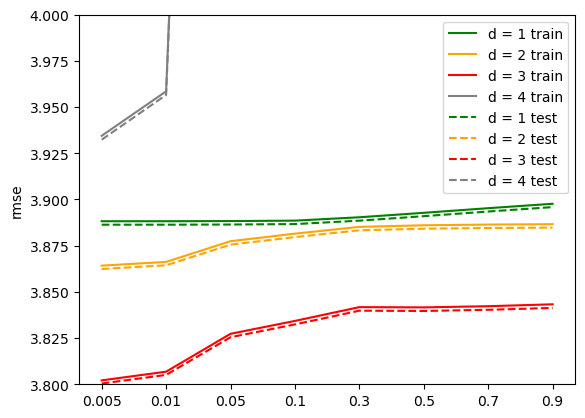

In [30]:
colors = ['green', 'orange', 'red', 'gray', 'purple'][:len(degrees)]
for i, row in enumerate(train_hist):
    plt.plot(range(len(alphas)), row, label='d = {} train'.format(degrees[i]), color=colors[i])

for i, row in enumerate(test_hist):
    plt.plot(range(len(alphas)), row, label='d = {} test'.format(degrees[i]), linestyle='--', color=colors[i])
    plt.legend()

plt.ylim(3.8, 4.0)
plt.xticks(range(len(alphas)), alphas)    
plt.ylabel('rmse')
plt.legend()
plt.show()